<a href="https://colab.research.google.com/github/icculp/holbertonschool-machine_learning/blob/main/supervised_learning/0x0E-time_series/foreast_bitcoin_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [284]:
df = pd.read_csv('coinbase.csv')
df = df[::10]
print(df.head)
print(df.columns)
columns = df.columns

<bound method NDFrame.head of           Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
0        1417411980   300.00  ...           3.000000      300.000000
10       1417550520   378.00  ...           3.780000      378.000000
20       1418179320   398.00  ...           3.980000      398.000000
30       1420680540   344.67  ...           3.446700      344.670000
40       1420681140   326.10  ...           9.922900      330.763333
...             ...      ...  ...                ...             ...
1990650  1546896360  4009.06  ...       21610.381244     4009.860365
1990660  1546896960  4011.51  ...        2481.976711     4011.504804
1990670  1546897560  4018.02  ...       18768.274910     4016.160149
1990680  1546898160  4010.81  ...        5241.132727     4009.813694
1990690  1546898760  4005.51  ...        7021.183546     4005.745614

[199070 rows x 8 columns]>
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],

In [285]:
''' keep datetime for plot x-axis '''
date_time = pd.to_datetime(df.pop('Timestamp'), unit='s') # format='%d.%m.%Y %H:%M:%S')

In [286]:
print(date_time)

0         2014-12-01 05:33:00
10        2014-12-02 20:02:00
20        2014-12-10 02:42:00
30        2015-01-08 01:29:00
40        2015-01-08 01:39:00
                  ...        
1990650   2019-01-07 21:26:00
1990660   2019-01-07 21:36:00
1990670   2019-01-07 21:46:00
1990680   2019-01-07 21:56:00
1990690   2019-01-07 22:06:00
Name: Timestamp, Length: 199070, dtype: datetime64[ns]


In [287]:
''' perform dimensionality reduction using PCA '''
pca = PCA(n_components=2, svd_solver='full')
df = pd.DataFrame(pca.fit_transform(df), columns=columns[0:2])

In [288]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [289]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [290]:
print(train_mean)

Timestamp   -25407.692847
Open          3995.151964
dtype: float64


In [291]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [292]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [293]:
def plot(self, model=None, plot_col='Open', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    # * train_std + train_mean,
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [294]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [295]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [296]:
#LABEL_WIDTH = 24
#INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_window = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=1,
    label_columns=['Open'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['Open']

In [297]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [298]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 2)
Output shape: (32, 1)


In [299]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [300]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [301]:
history = compile_and_fit(lstm_model, wide_window)
val_performance = {}
performance = {}
# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/10
4354/4354 [==============================] - 32s 7ms/step - loss: 0.0801 - mean_absolute_error: 0.0923 - val_loss: 5.7723 - val_mean_absolute_error: 1.4083
Epoch 2/10
4354/4354 [==============================] - 30s 7ms/step - loss: 0.0611 - mean_absolute_error: 0.0739 - val_loss: 5.4009 - val_mean_absolute_error: 1.2928
Epoch 3/10
4354/4354 [==============================] - 30s 7ms/step - loss: 0.0603 - mean_absolute_error: 0.0726 - val_loss: 5.5749 - val_mean_absolute_error: 1.3550
Epoch 4/10
1244/1244 [==============================] - 5s 4ms/step - loss: 5.5404 - mean_absolute_error: 1.3258


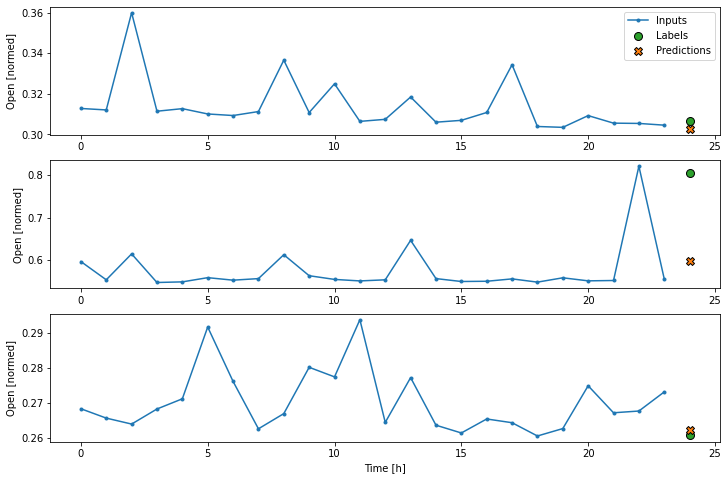

In [302]:
 ''' normalized output predictions '''
 wide_window.plot(lstm_model)